In [2]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import lognorm, anderson, kstest
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from datetime import datetime

date = '0304'
nbins = 100
dfdf

data_dir = f'input_data/s1_pixels/{date}/'
files = sorted(glob(data_dir + '*.csv'))
results_list = []
# files_sample = np.random.choice(files, 16, replace=False)
# fig, ax = plt.subplots(4, 4, figsize=(8, 8))
# axs = ax.flatten()                  
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
      f'-- Starting {len(files)} pixel files.')
for i in range(len(files)):
    # Read data
    pixel_id = files[i].split('s1_')[-1].split('.')[0]
    data = pd.read_csv(files[i], index_col=0)
    data[data['std_dev'] == 0] = np.nan
    data.dropna(inplace=True)
    # Calculate bins by percentile
    p1 = data['std_dev'].quantile(0.001)
    p99 =  data['std_dev'].quantile(0.999)
    bins_log = np.logspace(np.log10(p1), np.log10(p99), nbins)
    
    # scale = mean (np.exp(mu)); shape = SD (sigma); force loc = 0
    shape, loc, scale = lognorm.fit(data['std_dev'], floc=0)
    # Create CDF from fitted model, take difference for smooth PDF
    estimated_cdf = lognorm.cdf(bins_log, shape, loc=loc, scale=scale)
    estimated_pdf = np.diff(estimated_cdf)
    # Anderson-Darling and K-S statistic
    ad_stat, crit_vals, sig_levels = anderson(data['std_dev'], dist='logistic')
    ks_stat, ks_pval = kstest(data['std_dev'], 'lognorm', args=(shape, loc, scale))
    results = [pixel_id, scale, shape, ks_stat, ad_stat]
    results_list.append(results)
    if i != 0 and not i%100:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
              f'-- {i} files complete.')
#     #Plotting
#     # Find histogram bin centers for plotting
#     bins_log_cntr = (bins_log[1:] + bins_log[:-1]) / 2
#     counts, bin_edges, ignored = axs[i].hist(data['std_dev'], bins_log)
#     # Need to scale PDF by bin heights to align on plot
#     axs[i].plot(bins_log_cntr, estimated_pdf * counts.sum(), 'r--', lw=2)
#     axs[i].set_xscale('log')
#     axs[i].set_xlim(bin_edges.min(), bin_edges.max())
#     axs[i].text(0.65, 0.7, f'D = {round(ks_stat, 3)}\n$\mu$ = {round(scale, 3)}\n$\sigma$ = {round(shape, 3)}', 
#                 transform=axs[i].transAxes, fontsize=6)
#     axs[i].set_title('Pixel ID ' + files_sample[i].split('s1_')[-1].split('.')[0], fontsize=10)
#     axs[i].tick_params(labelleft=False)

results_df = pd.DataFrame(results_list, columns=['pixel_id','scale','shape','ks','ad'])
results_df.to_csv(f'output/stats/{date}.csv')
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
      f'-- All {len(files)} files complete.')
#plt.tight_layout()

NameError: name 'dfdf' is not defined

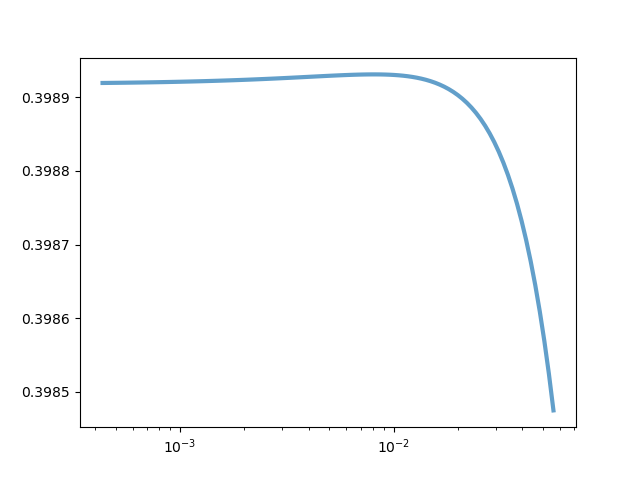

In [7]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.neighbors import KernelDensity
#f = 'input_data/s1_pixels/0218\\s1_1114.csv' # normal
#f = 'input_data/s1_pixels/0218\\s1_417.csv' # skewed left
f = 'input_data/s1_pixels/0218\\s1_1347.csv' # skewed left

data = pd.read_csv(f, index_col=0)
data[data['std_dev'] == 0] = np.nan
data.dropna(inplace=True)
sample = np.random.choice(data['std_dev'].values, 10000).reshape(-1,1)

p1_new = data['std_dev'].quantile(0.001)
p99_new =  data['std_dev'].quantile(0.999)
bins_log_new = np.logspace(np.log10(p1_new), np.log10(p99_new), nbins)

kde = KernelDensity(bandwidth=1.0, rtol=1e-4, kernel='gaussian').fit(sample)
plot_x = np.logspace(p1_new, p99_new, 1000)
log_pdf = kde.score_samples(bins_log_new.reshape(-1,1))
pdf = np.exp(log_pdf)


fig, ax = plt.subplots()
#ax.hist(data['std_dev'], bins_log_new, fc='gray', histtype='stepfilled', density=True)
ax.plot(bins_log_new, pdf, lw=3, alpha=0.7)
ax.set_xscale('log')

# bandwidths = 10 ** np.linspace(-1, 1, 10)
# grid = GridSearchCV(KernelDensity(kernel='gaussian'),
#                     {'bandwidth': bandwidths},
#                     cv=3)
# grid.fit(data['std_dev'].values.reshape(-1,1))
# grid.best_params_

In [20]:
pdf = np.exp(kde.score_samples(x_grid[:, None]))

KernelDensity(rtol=0.0001)

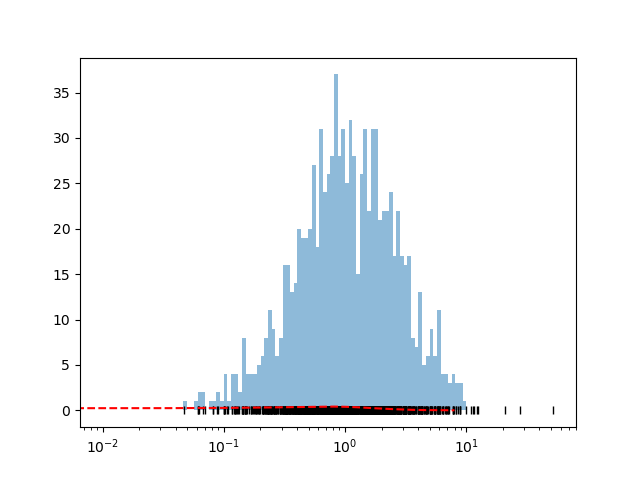

In [91]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
#     x = rand.randn(N)
#     x[int(f * N):] += 5
    x = lognorm.rvs(s=1, size=1000, random_state=rand)
    
    return x

x = make_data(1000)
x_d = np.linspace(-4, 8, 1000)
x_d_log = np.logspace(-2, 1, 100)

from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

fig, ax = plt.subplots()
ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
ax.hist(x, x_d_log, density=False, alpha=0.5)
ax.plot(x_d, np.exp(logprob), 'r--', alpha=1)
ax.set_xscale('log')
#ax.set_ylim(-0.02, 0.22)